<h1><center><b>UNSUPERVISED LEARNING PROJECT</b></center></h1>



<img src="h.jpg" alt="Drawing" style="width: 800px;"/>

### 1.Libraries

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import requests
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans, DBSCAN, hierarchical
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

### 2.Functions

In [2]:
def csv_hero_raw():
    """
    Create a csv file by accessing an api to get information.

    Parameters
    ----------
    None

    Returns
    -------
    csv
    """
    lista_hero =[['name','eye_color','gender','hair_color','height','race','weight',
                    'combat','durability','intelligence','power','speed','strength']]
    
    for i in tqdm(range(1,732)):
        request = requests.get(f'https://superheroapi.com/api/2719432488102887/{i}')
        soup = BeautifulSoup(request.content,'html.parser').prettify()
        dict_ = json.loads(soup)
        
        #get attributes of character
        try:
            lista_hero.append([ dict_['name'],
                                dict_['appearance']['eye-color'],
                                dict_['appearance']['gender'],
                                dict_['appearance']['hair-color'],
                                dict_['appearance']['height'][-1],
                                dict_['appearance']['race'],
                                dict_['appearance']['weight'][-1],
                                dict_['powerstats']['combat'],
                                dict_['powerstats']['durability'],
                                dict_['powerstats']['intelligence'],
                                dict_['powerstats']['power'],
                                dict_['powerstats']['speed'],
                                dict_['powerstats']['strength'] ])
        except:
            print(f'error at {i} iteration.')

    pd.DataFrame(lista_hero[1:],columns=lista_hero[0]).to_csv('heroes_raw1.csv',index=False)
    

def plot_dendrogram(model, **kwargs):
    """
    Plot a dedrogram.
    
    "Originally extracted from class material.""

    Parameters
    ----------
    Model, others

    Returns
    -------
    Matplotlib plot.
    """
    # Children of hierarchical clustering
    children = model.children_
    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])
    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)
    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)  

### 3. Data Set

In [3]:
hero = pd.read_csv('heroes_raw.csv')

In [4]:
hero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
name            731 non-null object
eye_color       731 non-null object
gender          731 non-null object
hair_color      731 non-null object
height          731 non-null object
race            429 non-null object
weight          731 non-null object
combat          566 non-null float64
durability      566 non-null float64
intelligence    566 non-null float64
power           566 non-null float64
speed           566 non-null float64
strength        629 non-null float64
dtypes: float64(6), object(7)
memory usage: 74.4+ KB


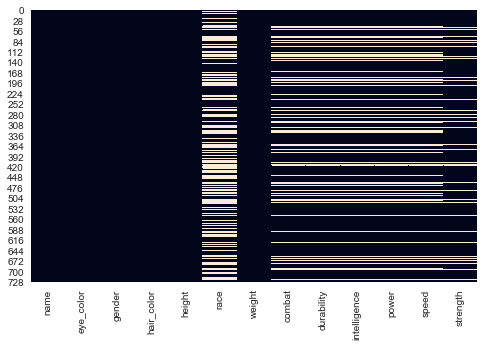

In [5]:
plt.figure(figsize=(8,5));sns.heatmap(hero.isnull(), cbar=False);

In [6]:
hero.describe()

,combat,durability,intelligence,power,speed,strength
count,566.000000,566.000000,566.000000,566.000000,566.000000,629.000000
mean,61.597173,58.973498,64.445230,64.243816,40.249117,44.001590
std,23.349979,30.060311,19.989369,29.797914,24.416224,32.886676
min,5.000000,1.000000,6.000000,0.000000,1.000000,4.000000
25%,42.000000,30.000000,50.000000,38.000000,23.000000,10.000000
50%,64.000000,60.000000,63.000000,63.500000,33.000000,35.000000
75%,80.000000,89.750000,75.000000,100.000000,50.000000,80.000000
max,101.000000,110.000000,100.000000,100.000000,100.000000,100.000000


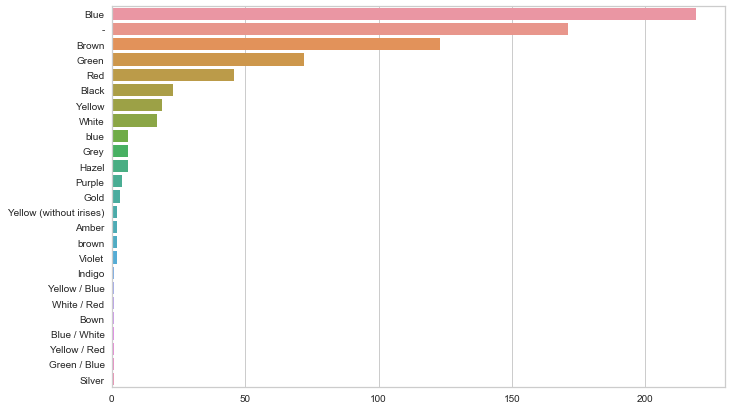

In [7]:
plt.figure(figsize=(11,7))
sns.barplot(x=hero.eye_color.value_counts().values,y=hero.eye_color.value_counts().index,data=hero);

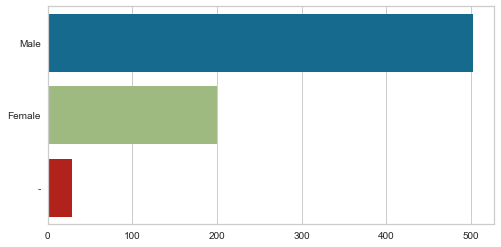

In [8]:
plt.figure(figsize=(8,4))
sns.barplot(x=hero.gender.value_counts().values,y=hero.gender.value_counts().index,data=hero);

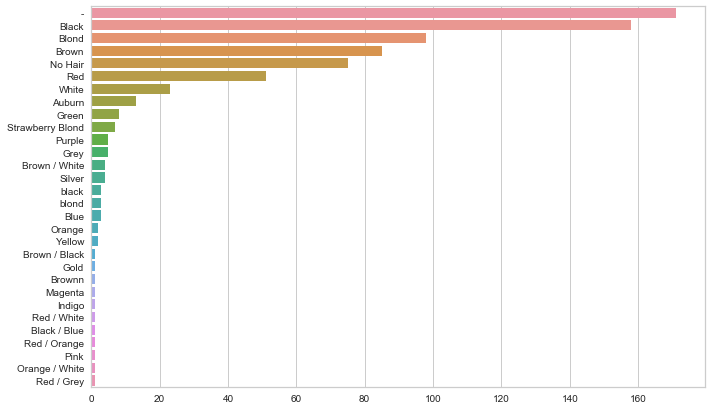

In [9]:
plt.figure(figsize=(11,7))
sns.barplot(x=hero.hair_color.value_counts().values,y=hero.hair_color.value_counts().index,data=hero);

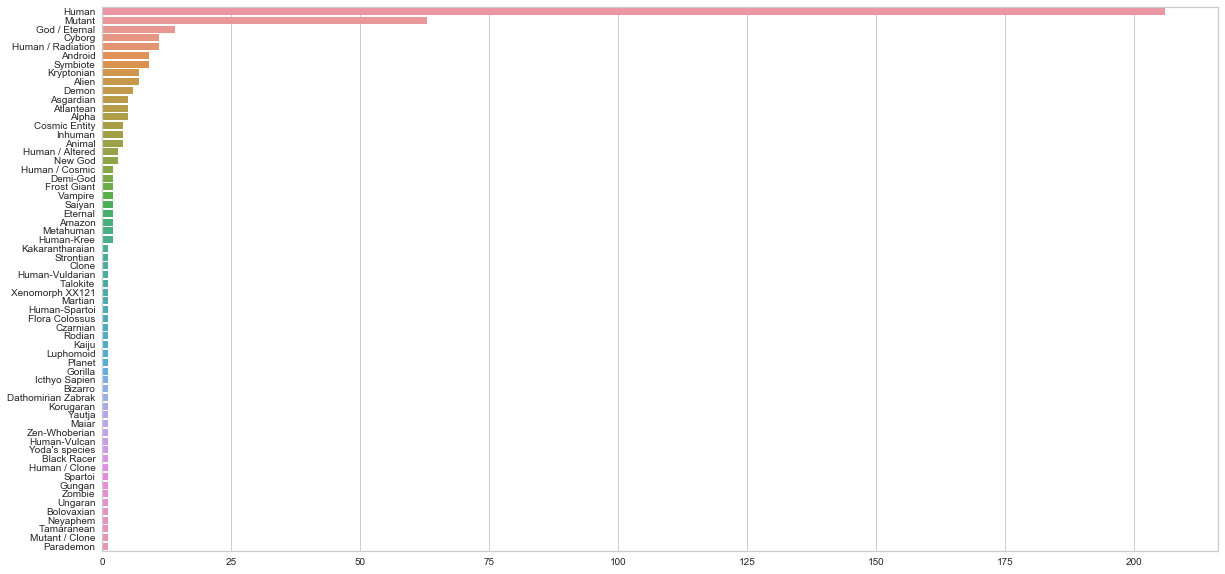

In [10]:
plt.figure(figsize=(20,10))
sns.barplot(x=hero.race.value_counts().values,y=hero.race.value_counts().index,data=hero);

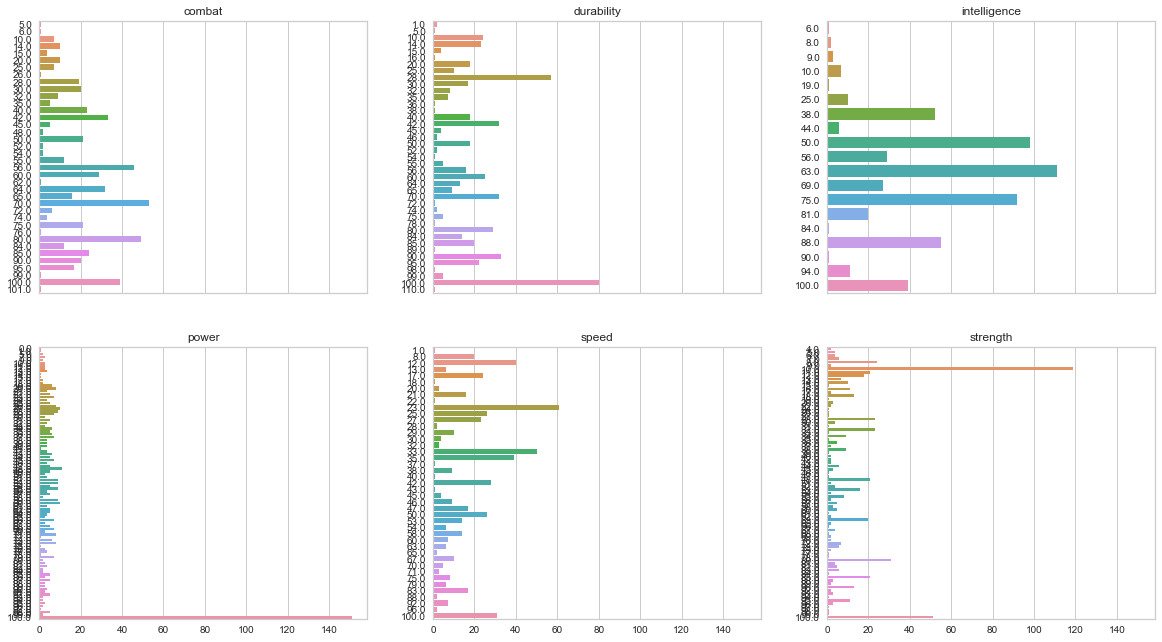

In [11]:
f, axes = plt.subplots(2,3,figsize=(20, 11), sharex=True)
sns.barplot(x=hero.combat.value_counts().values,y=hero.combat.value_counts().index,data=hero,orient='h', ax=axes[0,0]).set_title('combat');
sns.barplot(x=hero.durability.value_counts().values,y=hero.durability.value_counts().index,data=hero,orient='h', ax=axes[0,1]).set_title('durability');
sns.barplot(x=hero.intelligence.value_counts().values,y=hero.intelligence.value_counts().index,data=hero,orient='h', ax=axes[0,2]).set_title('intelligence');
sns.barplot(x=hero.power.value_counts().values,y=hero.power.value_counts().index,data=hero,orient='h', ax=axes[1,0]).set_title('power');
sns.barplot(x=hero.speed.value_counts().values,y=hero.speed.value_counts().index,data=hero,orient='h', ax=axes[1,1]).set_title('speed');
sns.barplot(x=hero.strength.value_counts().values,y=hero.strength.value_counts().index,data=hero,orient='h', ax=axes[1,2]).set_title('strength');

### 4. Data Cleaning/Manipulation:

#### 4.1.1 Adjusting Height an Weight columns

In [12]:
hero.height.unique()

array(['203 cm', '191 cm', '185 cm', '0 cm', '193 cm', '173 cm', '178 cm',
       '188 cm', '180 cm', '244 cm', '257 cm', '183 cm', '165 cm',
       '163 cm', '211 cm', '61.0 meters', '229 cm', '213 cm', '175 cm',
       '198 cm', '168 cm', '170 cm', '201 cm', '218 cm', '30.5 meters',
       '196 cm', '157 cm', '226 cm', 'Shaker Heights, Ohio', '267 cm',
       '122 cm', '975 cm', '142 cm', '876 cm', '62.5 meters',
       '108.0 meters', '701 cm', '259 cm', '79 cm', '155 cm', '71 cm',
       '287 cm', '234 cm', '64 cm', '366 cm', '206 cm', '305 cm',
       '297 cm', '137 cm', '279 cm', '15.2 meters', '140 cm', '160 cm',
       '304.8 meters', '66 cm'], dtype=object)

In [13]:
hero.weight.unique()

array(['441 kg', '65 kg', '90 kg', '0 kg', '122 kg', '88 kg', '61 kg',
       '81 kg', '104 kg', '108 kg', '72 kg', '169 kg', '173 kg', '101 kg',
       '68 kg', '57 kg', '54 kg', '83 kg', '86 kg', '358 kg', '135 kg',
       '106 kg', '146 kg', '63 kg', '98 kg', '270 kg', '59 kg', '50 kg',
       '126 kg', '67 kg', '180 kg', '77 kg', '52 kg', '95 kg', '79 kg',
       '133 kg', '181 kg', '216 kg', '71 kg', '124 kg', '155 kg',
       '113 kg', '58 kg', '92 kg', '97 kg', '56 kg', '230 kg', '495 kg',
       '55 kg', '110 kg', '99 kg', '158 kg', '74 kg', '116 kg', '62 kg',
       '170 kg', '70 kg', '78 kg', '225 kg', '817 kg', '27 kg', '91 kg',
       '178 kg', '383 kg', '171 kg', '187 kg', '132 kg', '89 kg',
       '412 kg', '306 kg', '80 kg', '203 kg', '96 kg', '18 tons', '45 kg',
       '167 kg', '16 tons', '630 kg', '268 kg', '90,000 tons', '115 kg',
       '4 tons', '48 kg', '18 kg', '119 kg', '207 kg', '191 kg', '2 tons',
       '14 kg', '49 kg', '855 kg', '356 kg', '324 kg', '9,000 t

In [14]:
#Adjusting height column
hero.loc[:,'height'] = hero.height.apply(lambda x : float(x.replace(" cm",""))/100 if "cm" in x 
                                         else (float(x.replace(" meters","")) if "meters" in x 
                                         else 0))

#Adjusting weight column
hero.loc[:,'weight'] = hero.weight.apply(lambda x : int(re.sub('[^(\S*\,\S*)]|[^(\d*)]','',x)) if "kg" in x 
                                         else int(re.sub('[^(\S*\,\S*)]|[^(\d*)]','',x))*1000)

#### 4.1.2 Dealing with zero 'height' and 'weight'

In [15]:
hero[(hero['height'] == 0) | (hero['weight'] == 0)].count()

name            241
eye_color       241
gender          241
hair_color      241
height          241
race            105
weight          241
combat          131
durability      131
intelligence    131
power           131
speed           131
strength        168
dtype: int64

In [16]:
# median measurement
mm = hero.loc[(hero['height'] != 0) | (hero['weight'] != 0)].groupby('race',as_index=False).agg('median')[['race','height','weight']]
mm

,race,height,weight
0,Alien,1.930,99.5
1,Amazon,1.790,68.5
2,Android,1.970,140.5
3,Animal,15.860,4500012.5
4,Asgardian,1.930,225.0
5,Atlantean,1.780,106.0
6,Bizarro,1.910,155.0
7,Black Racer,1.830,88.0
8,Bolovaxian,2.340,324.0
9,Clone,1.930,113.0


In [17]:
#Converting zeros to median measurement
hero.loc[:,'height'] = hero.height.apply(lambda x: mm.loc[mm.race == (hero.loc[x,'race']),'height'].values[0] if x ==0 else x)
hero.loc[:,'weight'] = hero.weight.apply(lambda x: mm.loc[mm.race == (hero.loc[x,'race']),'weight'].values[0] if x ==0 else x)

In [18]:
hero[(hero['height'] == 0) | (hero['weight'] == 0)].count()

name            0
eye_color       0
gender          0
hair_color      0
height          0
race            0
weight          0
combat          0
durability      0
intelligence    0
power           0
speed           0
strength        0
dtype: int64

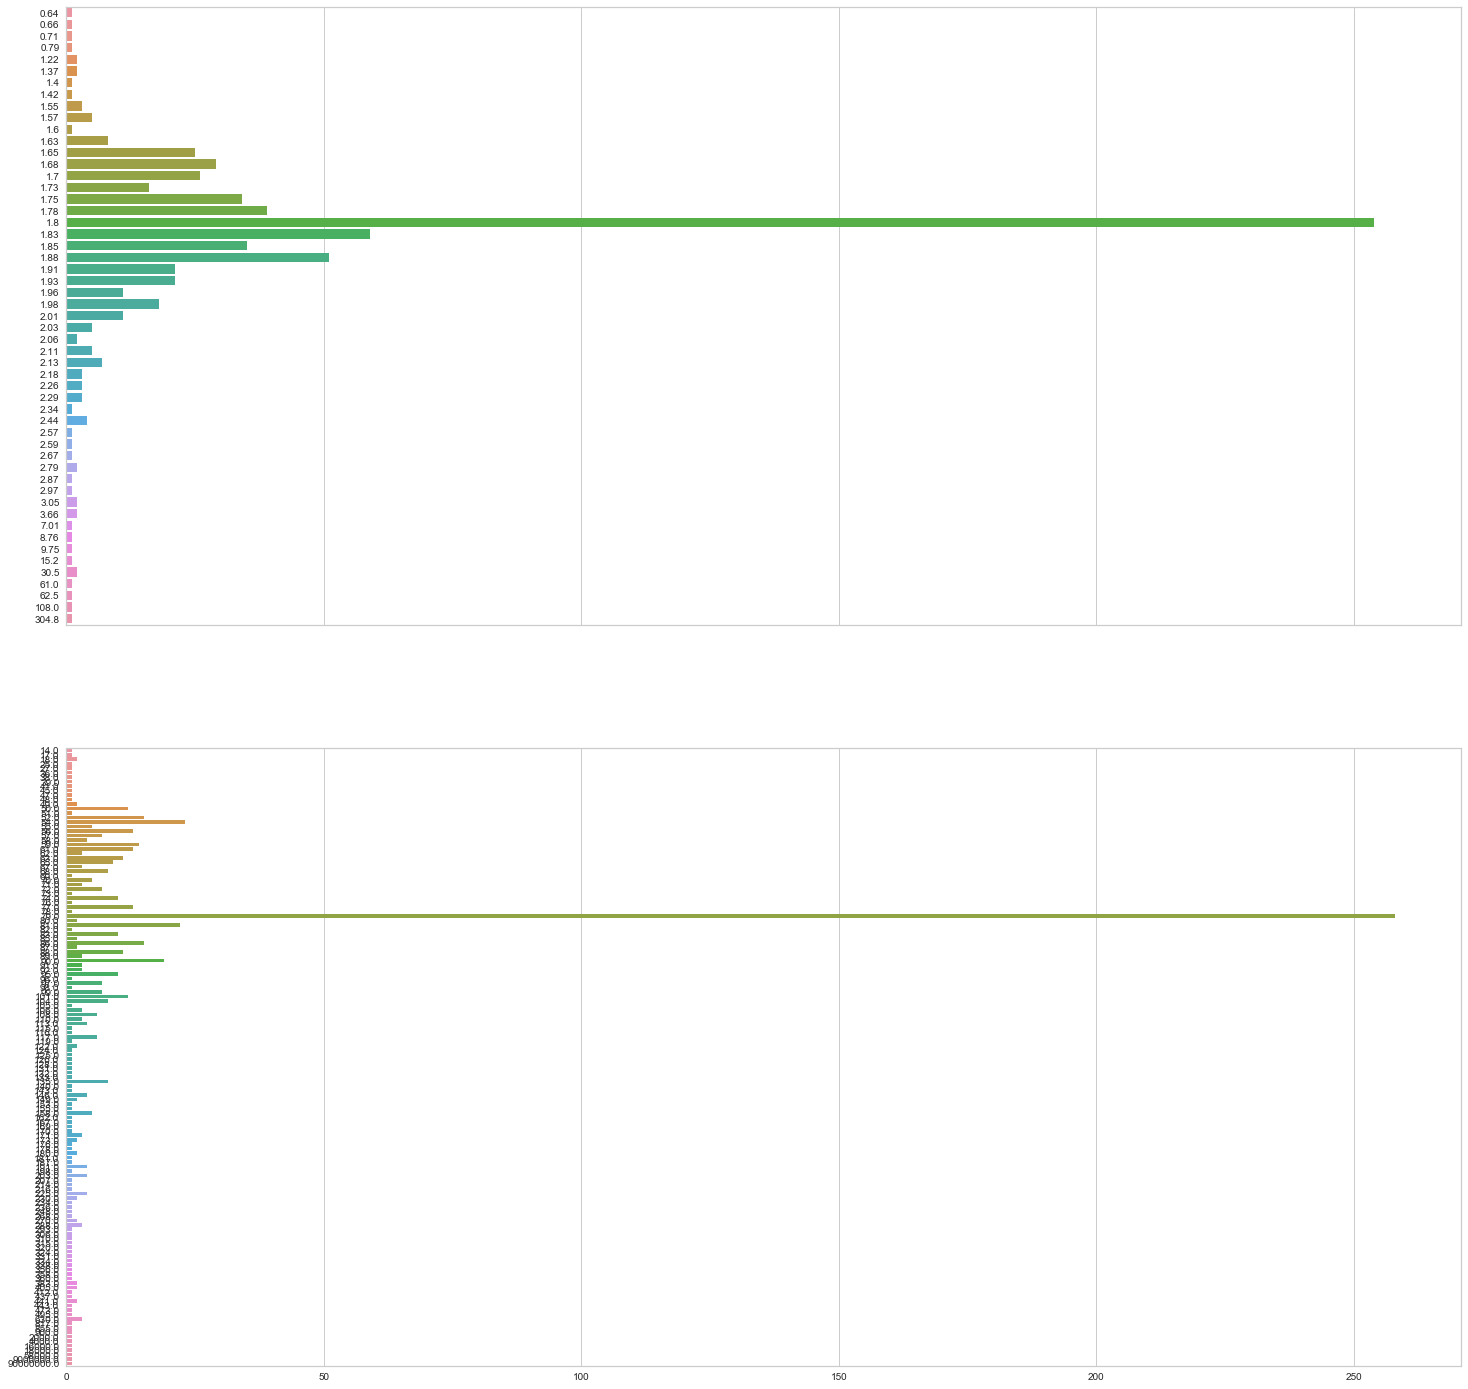

In [19]:
f, axes = plt.subplots(2,1,figsize=(25, 25), sharex=True)
sns.barplot(x=hero.height.value_counts().values,y=hero.height.value_counts().index,data=hero,orient='h',ax=axes[0]);
sns.barplot(x=hero.weight.value_counts().values,y=hero.weight.value_counts().index,data=hero,orient='h',ax=axes[1]);

#### 4.2 Adjusting 'eye_color', 'gender', 'hair_color' and 'race'

In [20]:
#Eyes:
hero.loc[:,'eye_color'] = hero.eye_color.replace(to_replace='-',value='undefined').apply(lambda x: 'eye_'+x.lower())
top4_eyes = hero.eye_color.value_counts().nlargest(4).index
dummy_eye = pd.get_dummies(hero.eye_color.where(hero.eye_color.isin(top4_eyes), other='eye_other_colors'))

#Gender:
hero.loc[:,'gender'] = hero.gender.replace(to_replace='-',value='undefined').apply(lambda x: 'gender_'+x.lower())
dummy_gender = pd.get_dummies(hero.gender)

#Hair:
hero.loc[:,'hair_color'] = hero.hair_color.replace(to_replace='-',value='undefined').apply(lambda x: 'hair_'+x.lower().replace(" ",'_'))
top5_hair = hero.hair_color.value_counts().nlargest(5).index
dummy_hair = pd.get_dummies(hero.hair_color.where(hero.hair_color.isin(top5_hair), other='hair_other_colors'))

#Race:
hero.race.fillna(value='undefined',inplace=True)
hero.loc[:,'race'] = hero.race.apply(lambda x: 'race_'+x.lower())
top2_race = hero.race.value_counts().nlargest(2).index
dummy_race = pd.get_dummies(hero.race.where(hero.race.isin(top2_race), other='race_other_races'))

#Unifying data frames:
hero = pd.concat([hero, dummy_eye, dummy_hair, dummy_gender, dummy_race],axis=1)

#### 4.3 Dealing with NaN Values:

In [21]:
#Creating a new data frame without nan values:
dhero = hero.dropna()
dhero[[col for col in dhero.columns if col not in ['name','eye_color','gender','hair_color','race']]].to_csv('hero_removed.csv',index=False)

#Replacing missing values by the median
hero.loc[:,'combat'] = hero['combat'].fillna((hero['combat'].median()))
hero.loc[:,'durability'] = hero['durability'].fillna((hero['durability'].median()))
hero.loc[:,'intelligence'] = hero['intelligence'].fillna((hero['intelligence'].median()))
hero.loc[:,'power'] = hero['power'].fillna((hero['power'].median()))
hero.loc[:,'speed'] = hero['speed'].fillna((hero['speed'].median()))
hero.loc[:,'strength'] = hero['strength'].fillna((hero['strength'].median()))

#### 4.4 Dealing with outliers:
    -Rule of Thumb: Numbers higher than (1.5 X IQR) + Q3 are outliers

In [22]:
iqr_height = hero.height.quantile(0.75) - hero.height.quantile(0.25)
iqr_weight = hero.weight.quantile(0.75) - hero.weight.quantile(0.25)
out_h = (1.5*iqr_height) + hero.height.quantile(0.75)
out_w = (1.5*iqr_weight) + hero.weight.quantile(0.75)

outliers = hero.loc[(hero['weight']> out_w ) | (hero['height']> out_h)]
outliers.to_csv('outliers.csv')

#### 4.4.1 Removing outliers:

In [23]:
hero = hero.loc[(hero['weight'] <= out_w ) | (hero['height'] <= out_h)]

#### 4.5 Correlation Matrix and last adjustments

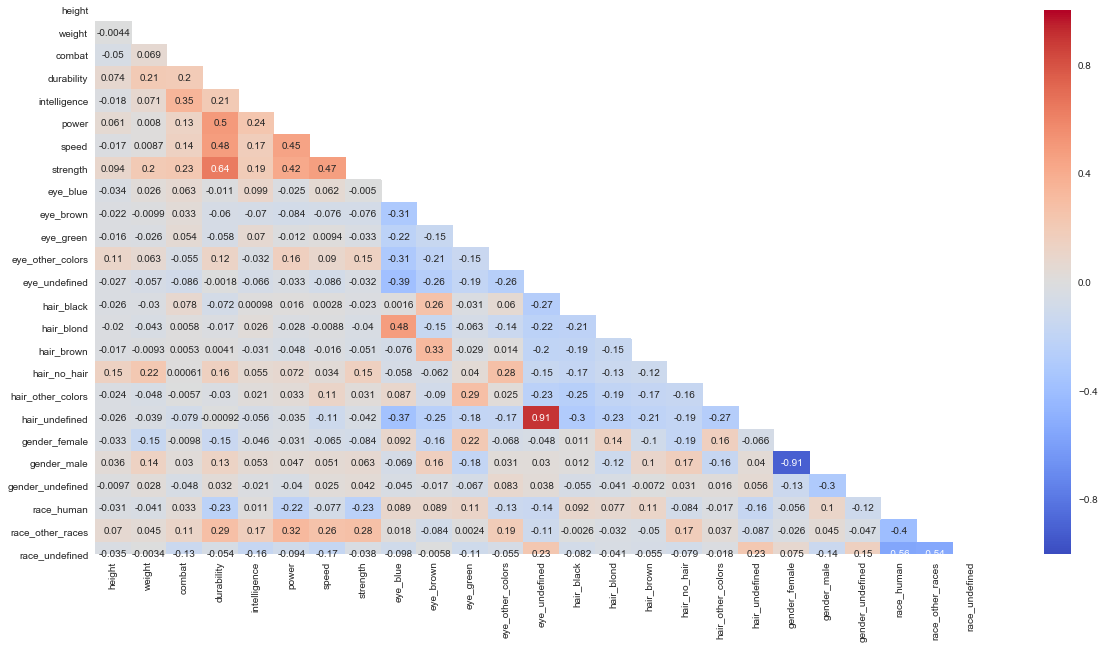

In [24]:
mask = np.zeros_like(hero.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(hero.corr(),
            mask=mask,
            vmin=-1,
            vmax=1,
            annot=True,
            annot_kws = {"size": 10},
            cmap='coolwarm');

In [25]:
hero.drop(columns=['eye_undefined','gender_female'],inplace=True)

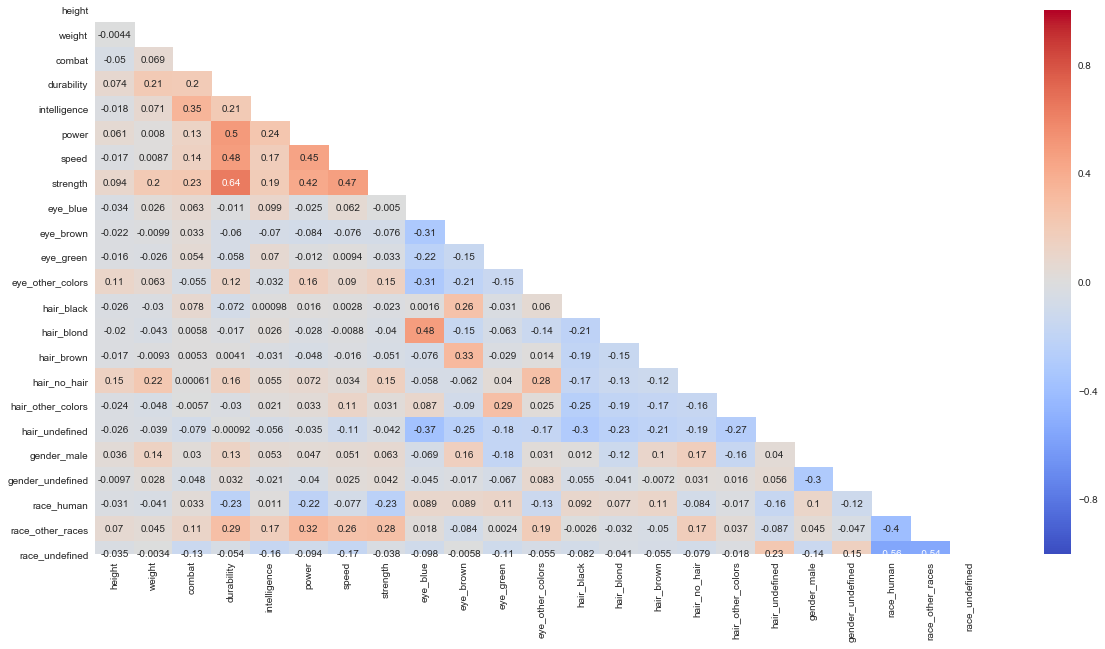

In [26]:
mask = np.zeros_like(hero.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)]= True
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(hero.corr(),mask=mask,vmin=-1,vmax=1,annot=True,annot_kws = {"size": 10},cmap='coolwarm');

In [27]:
#Saving new data frame to csv:
hero[[col for col in hero.columns if col not in ['name','eye_color','gender','hair_color','race']]].to_csv('hero_replaced.csv',index=False)

### 5. Unsupervised Learning Models

In [28]:
heroes = pd.read_csv('hero_replaced.csv')

In [29]:
heroes.shape

(692, 23)

In [30]:
heroes.head()

,height,weight,combat,durability,intelligence,power,speed,strength,eye_blue,eye_brown,...,hair_blond,hair_brown,hair_no_hair,hair_other_colors,hair_undefined,gender_male,gender_undefined,race_human,race_other_races,race_undefined
0,2.03,441.0,64.0,80.0,38.0,24.0,17.0,100.0,0,0,...,0,0,1,0,0,1,0,1,0,0
1,1.91,65.0,85.0,65.0,88.0,100.0,35.0,28.0,1,0,...,0,0,1,0,0,1,0,0,1,0
2,1.85,90.0,65.0,64.0,50.0,99.0,53.0,90.0,1,0,...,0,0,1,0,0,1,0,0,1,0
3,2.03,441.0,95.0,90.0,63.0,62.0,53.0,80.0,0,0,...,0,0,1,0,0,1,0,0,1,0
4,1.80,79.0,55.0,100.0,88.0,100.0,83.0,63.0,1,0,...,0,0,0,0,0,1,0,0,1,0


#### 5.1 Preprocessing:

In [31]:
scaler = StandardScaler()

data_heroes = scaler.fit_transform(heroes)

#### 5.2 Finding optimal number of clusters:

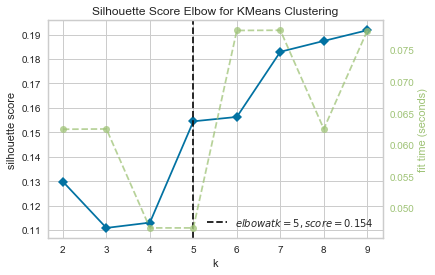

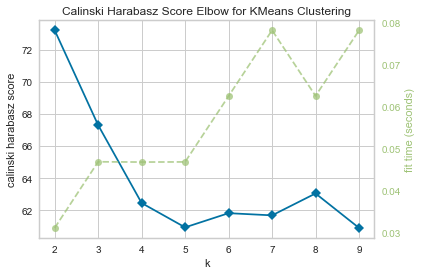

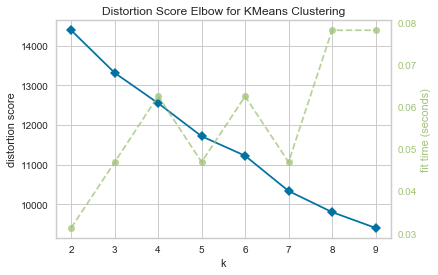

In [32]:
model = KMeans()

for metric in ['silhouette','calinski_harabasz','distortion']:
    visualizer = KElbowVisualizer(model, k=(2,10),metric=metric);
    visualizer.fit(data_heroes);
    visualizer.poof();

#### 5.3 PCA

In [33]:
pca = PCA(n_components=2)
dfpca = pca.fit_transform(data_heroes)
dfpca = pd.DataFrame(dfpca, columns=['pc1','pc2'])

#### 5.4.1 Model: Kmeans

In [34]:
k2 = KMeans(n_clusters=2)
k3 = KMeans(n_clusters=3)
k4 = KMeans(n_clusters=4)
k6 = KMeans(n_clusters=6)

k2_clusters = k2.fit_predict(data_heroes)
k3_clusters = k3.fit_predict(data_heroes)
k4_clusters = k4.fit_predict(data_heroes)
k6_clusters = k6.fit_predict(data_heroes)

heroes['k2_clusters'] = k2_clusters
heroes['k3_clusters'] = k3_clusters
heroes['k4_clusters'] = k4_clusters
heroes['k6_clusters'] = k6_clusters

print(heroes.k2_clusters.value_counts())
print("-------------------------------------")
print(heroes.k3_clusters.value_counts())
print("-------------------------------------")
print(heroes.k4_clusters.value_counts())
print("-------------------------------------")
print(heroes.k6_clusters.value_counts())

0    474
1    218
Name: k2_clusters, dtype: int64
-------------------------------------
0    290
2    213
1    189
Name: k3_clusters, dtype: int64
-------------------------------------
0    225
1    185
2    161
3    121
Name: k4_clusters, dtype: int64
-------------------------------------
2    168
0    148
5    119
4    115
1     79
3     63
Name: k6_clusters, dtype: int64


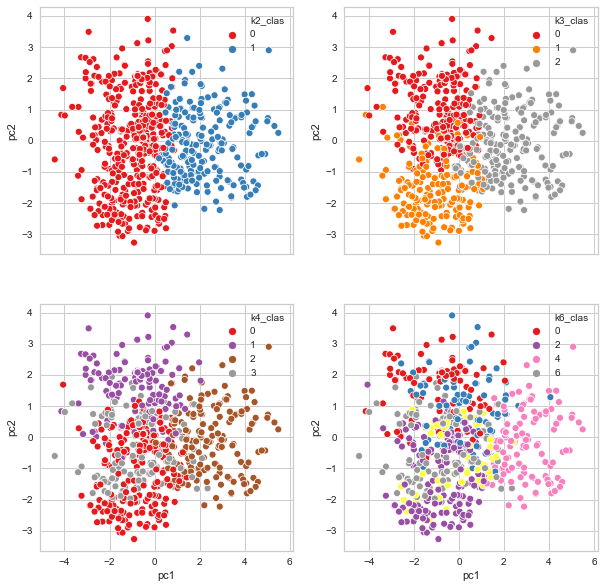

In [35]:
dfpca['k2_clas'] = k2_clusters
dfpca['k3_clas'] = k3_clusters
dfpca['k4_clas'] = k4_clusters
dfpca['k6_clas'] = k6_clusters

f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=True)
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(dfpca.pc1,dfpca.pc2, hue=dfpca.k2_clas, palette="Set1",ax=axes[0,0])
sns.scatterplot(dfpca.pc1,dfpca.pc2, hue=dfpca.k3_clas, palette="Set1",ax=axes[0,1])
sns.scatterplot(dfpca.pc1,dfpca.pc2, hue=dfpca.k4_clas, palette="Set1",ax=axes[1,0])
sns.scatterplot(dfpca.pc1,dfpca.pc2, hue=dfpca.k6_clas, palette="Set1",ax=axes[1,1])

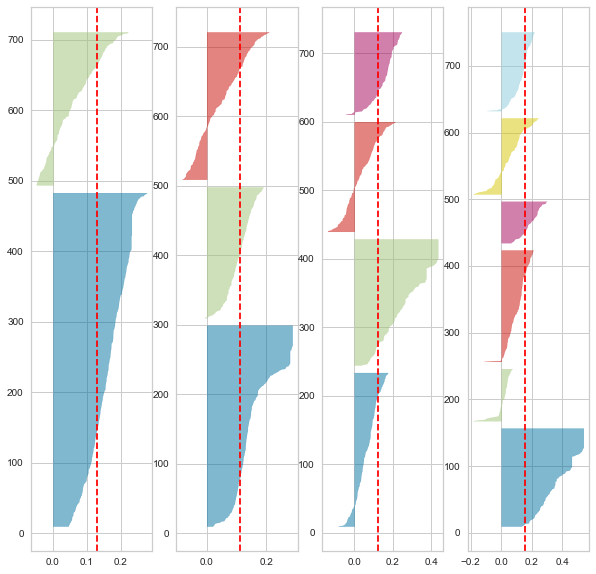

In [36]:
fig, ax = plt.subplots(1,4, figsize=(10,10))
# Instantiate the clustering model and visualizer
vs_k2 = SilhouetteVisualizer(k2, colors='yellowbrick', ax=ax[0]).fit(data_heroes)
vs_k3 = SilhouetteVisualizer(k3, colors='yellowbrick', ax=ax[1]).fit(data_heroes)   
vs_k4 = SilhouetteVisualizer(k4, colors='yellowbrick', ax=ax[2]).fit(data_heroes)  
vs_k6 = SilhouetteVisualizer(k6, colors='yellowbrick', ax=ax[3]).fit(data_heroes)

In [51]:
heroes.groupby('k3_clusters').agg('mean').T

k3_clusters,0,1,2
height,1.788621,1.783915,3.669953
weight,81.024138,81.000000,117.183099
combat,56.624138,62.751323,68.530516
durability,51.665517,44.783069,77.727700
intelligence,58.748276,64.238095,70.985915
power,57.615517,51.783069,81.382629
speed,30.824138,33.671958,52.873239
strength,34.617241,24.984127,63.624413
eye_blue,0.258621,0.407407,0.314554
eye_brown,0.168966,0.227513,0.136150


#### 5.4.2 Model: DBScan

In [38]:
db_euclid = DBSCAN(eps=4,p=10000,metric='euclidean').fit_predict(data_heroes)
db_man = DBSCAN(eps=4,p=1000000,metric='manhattan').fit_predict(data_heroes)
db_mink = DBSCAN(eps=3,p=100,metric='minkowski').fit_predict(data_heroes)


heroes['db_euclid'] = db_euclid
heroes['db_man'] = db_man
heroes['db_mink'] = db_mink

print(heroes.db_euclid.value_counts())
print("-------------------------------------")
print(heroes.db_man.value_counts())
print("-------------------------------------")
print(heroes.db_mink.value_counts())

 1    594
 0     60
-1     27
 2     11
Name: db_euclid, dtype: int64
-------------------------------------
-1     459
 2      77
 1      22
 5      22
 0      15
 4      14
 3      14
 9      13
 7      13
 8      10
 6      10
 11      7
 12      6
 13      5
 10      5
Name: db_man, dtype: int64
-------------------------------------
 1    469
 2     73
 0     53
 4     52
 5     19
-1     12
 3      8
 6      6
Name: db_mink, dtype: int64


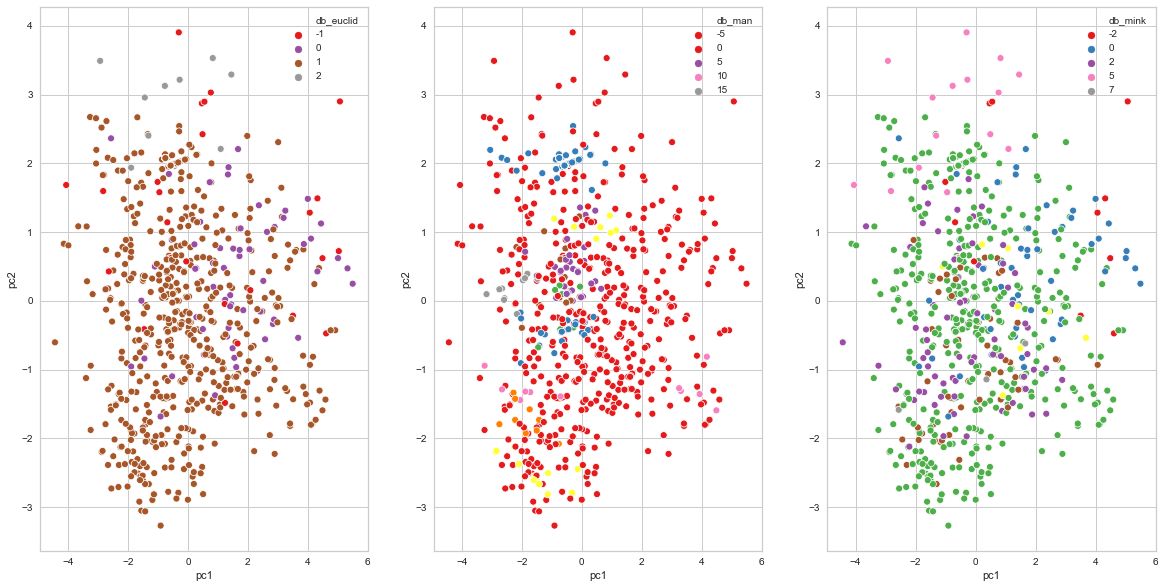

In [39]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
dfpca['db_euclid'] = db_euclid
dfpca['db_man'] = db_man
dfpca['db_mink'] = db_mink

sns.scatterplot(dfpca.pc1,dfpca.pc2, hue=dfpca.db_euclid, palette="Set1",ax=ax[0])
sns.scatterplot(dfpca.pc1,dfpca.pc2, hue=dfpca.db_man, palette="Set1",ax=ax[1])
sns.scatterplot(dfpca.pc1,dfpca.pc2, hue=dfpca.db_mink, palette="Set1",ax=ax[2])

In [40]:
heroes.groupby('db_euclid').agg('mean').T  
#heroes.groupby('db_man').agg('mean').T
#heroes.groupby('db_mink').agg('mean').T

db_euclid,-1,0,1,2
height,15.234815,2.352333,1.793401,1.800000
weight,195.851852,120.866667,84.707071,82.727273
combat,60.111111,62.083333,62.144781,56.000000
durability,69.296296,68.450000,56.215488,57.545455
intelligence,71.148148,66.166667,63.648148,54.545455
power,63.351852,68.041667,63.024411,54.590909
speed,41.851852,40.133333,38.101010,35.909091
strength,50.222222,53.066667,39.173401,45.818182
eye_blue,0.296296,0.233333,0.331650,0.000000
eye_brown,0.185185,0.116667,0.181818,0.090909


#### 5.4.3 Model: Hierarchical

In [41]:
h2 = hierarchical.AgglomerativeClustering(n_clusters=2)
h3 = hierarchical.AgglomerativeClustering(n_clusters=3)
h4 = hierarchical.AgglomerativeClustering(n_clusters=4)
h6 = hierarchical.AgglomerativeClustering(n_clusters=6)


h2_clusters = h2.fit_predict(data_heroes)
h3_clusters = h3.fit_predict(data_heroes)
h4_clusters = h4.fit_predict(data_heroes)
h6_clusters = h6.fit_predict(data_heroes)

heroes['h2_clusters'] = h2_clusters
heroes['h3_clusters'] = h3_clusters
heroes['h4_clusters'] = h4_clusters
heroes['h6_clusters'] = h6_clusters

print(heroes.h2_clusters.value_counts())
print("-------------------------------------")
print(heroes.h3_clusters.value_counts())
print("-------------------------------------")
print(heroes.h4_clusters.value_counts())
print("-------------------------------------")
print(heroes.h6_clusters.value_counts())

0    501
1    191
Name: h2_clusters, dtype: int64
-------------------------------------
0    437
1    191
2     64
Name: h3_clusters, dtype: int64
-------------------------------------
0    279
1    191
3    158
2     64
Name: h4_clusters, dtype: int64
-------------------------------------
0    201
3    163
1    158
4     78
2     64
5     28
Name: h6_clusters, dtype: int64


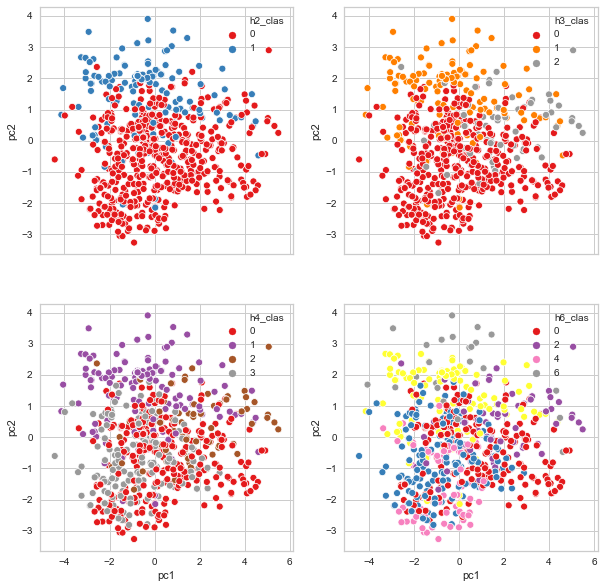

In [42]:
dfpca['h2_clas'] = h2_clusters
dfpca['h3_clas'] = h3_clusters
dfpca['h4_clas'] = h4_clusters
dfpca['h6_clas'] = h6_clusters

f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=True)
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(dfpca.pc1,dfpca.pc2, hue=dfpca.h2_clas, palette="Set1",ax=axes[0,0])
sns.scatterplot(dfpca.pc1,dfpca.pc2, hue=dfpca.h3_clas, palette="Set1",ax=axes[0,1])
sns.scatterplot(dfpca.pc1,dfpca.pc2, hue=dfpca.h4_clas, palette="Set1",ax=axes[1,0])
sns.scatterplot(dfpca.pc1,dfpca.pc2, hue=dfpca.h6_clas, palette="Set1",ax=axes[1,1])

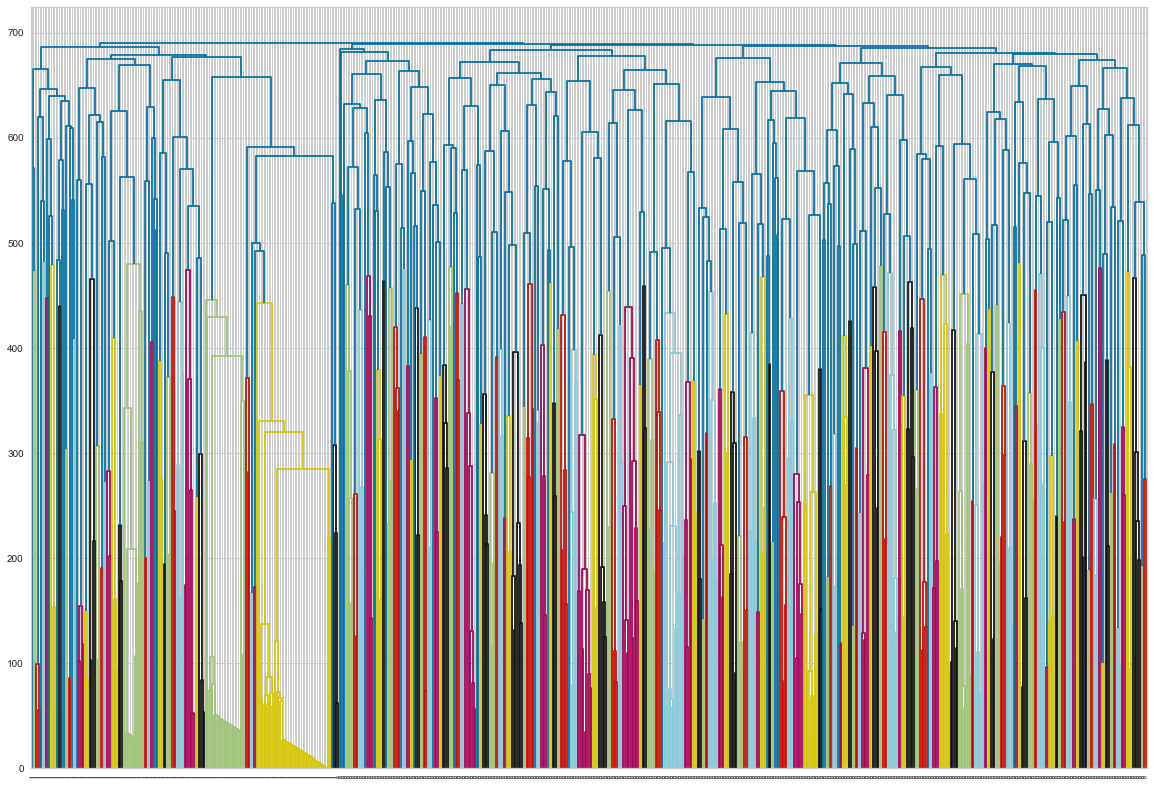

In [43]:
#plotting dendrogram:
plt.figure(figsize=(20,14))
plot_dendrogram(h2, labels=h2.labels_)

In [44]:
heroes.groupby('h3_clusters').agg('mean').T

h3_clusters,0,1,2
height,1.789176,1.805864,7.980781
weight,85.622426,86.376963,153.921875
combat,63.633867,57.989529,62.406250
durability,56.297483,57.141361,70.109375
intelligence,64.432494,62.209424,66.546875
power,63.662471,60.785340,68.742188
speed,38.958810,36.528796,40.046875
strength,40.013730,38.219895,55.109375
eye_blue,0.443936,0.052356,0.234375
eye_brown,0.247140,0.031414,0.109375


#### 5.4.4 Model: Gaussian Mixture Models

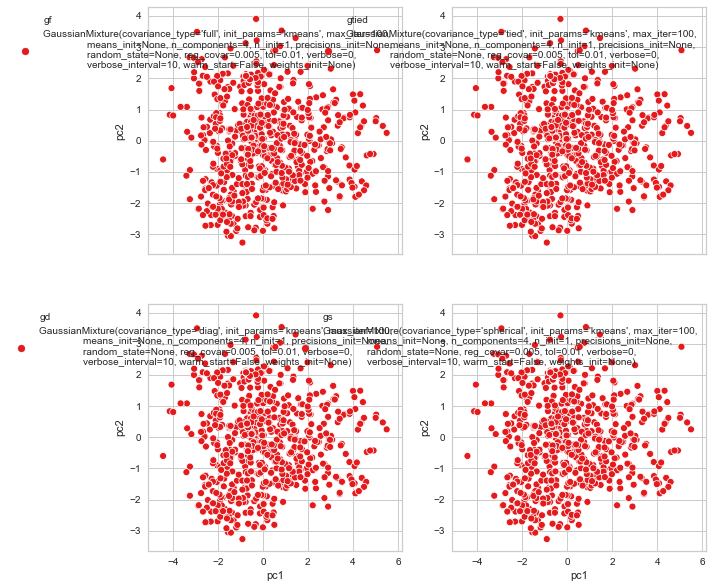

In [45]:
gf = GaussianMixture(n_components=4, covariance_type='full',reg_covar=0.005,tol=0.01 ).fit(data_heroes)
gt = GaussianMixture(n_components=4, covariance_type='tied',reg_covar=0.005,tol=0.01 ).fit(data_heroes)
gd = GaussianMixture(n_components=4, covariance_type='diag',reg_covar=0.005,tol=0.01 ).fit(data_heroes)
gs = GaussianMixture(n_components=4, covariance_type='spherical',reg_covar=0.005,tol=0.01 ).fit(data_heroes)

dfpca['gf'] = gf
dfpca['gtied'] = gt
dfpca['gd'] = gd
dfpca['gs'] = gs

f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=True)
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(dfpca.pc1,dfpca.pc2, hue=dfpca.gf, palette="Set1",ax=axes[0,0])
sns.scatterplot(dfpca.pc1,dfpca.pc2, hue=dfpca.gtied, palette="Set1",ax=axes[0,1])
sns.scatterplot(dfpca.pc1,dfpca.pc2, hue=dfpca.gd, palette="Set1",ax=axes[1,0])
sns.scatterplot(dfpca.pc1,dfpca.pc2, hue=dfpca.gs, palette="Set1",ax=axes[1,1])

#### 5.4.5 Model: TSNE

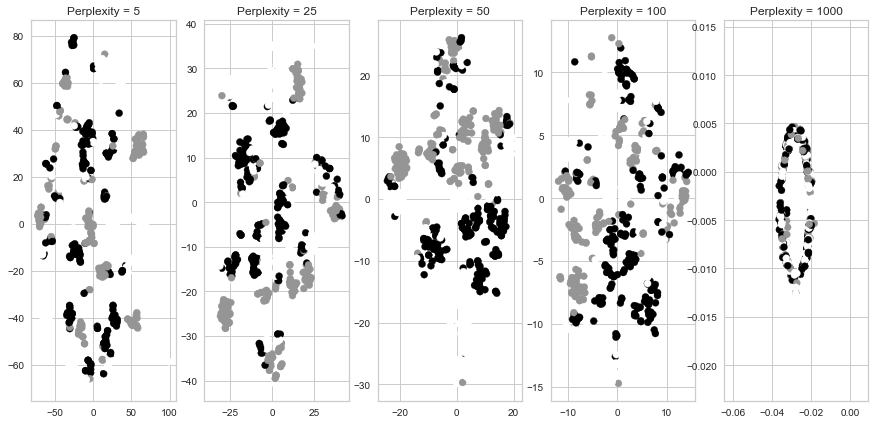

In [46]:
fig, ax = plt.subplots(1, 5, figsize=(15, 7))
for i, perp in enumerate([5, 25, 50, 100, 1000]):
    tsne = TSNE(perplexity=perp)
    x_embedded = tsne.fit_transform(data_heroes)
    ax[i].scatter(x_embedded[:, 0], x_embedded[:, 1],c=k3_clusters)
    ax[i].set_title("Perplexity = {}".format(perp))
    
plt.show()

# Misc

In [47]:
heroes_ = pd.concat([hero.loc[:,'name'],heroes],axis=1)

In [48]:
heroes_.loc[heroes_.name=="Superman"].T

,643
name,Superman
height,1.83
weight,82
combat,28
durability,14
intelligence,88
power,9
speed,12
strength,10
eye_blue,0


In [49]:
heroes_.loc[heroes_.name=="Batman"].T

,68,69
name,Batman,Batman
height,1.75,1.8
weight,63,181
combat,64,85
durability,60,60
intelligence,63,94
power,63.5,43
speed,33,38
strength,35,48
eye_blue,0,1


In [50]:
heroes_.loc[heroes_.name=="Joker"].T

,369
name,Joker
height,2.01
weight,203
combat,70
durability,40
intelligence,75
power,13
speed,25
strength,18
eye_blue,1


In [65]:
heroes_.loc[(heroes_['height']>3.67)]

,name,height,weight,combat,durability,intelligence,power,speed,strength,eye_blue,...,k3_clusters,k4_clusters,k6_clusters,db_euclid,db_man,db_mink,h2_clusters,h3_clusters,h4_clusters,h6_clusters
28,Annihilus,61.0,79.0,90.0,100.0,88.0,100.0,50.0,100.0,0.0,...,2.0,2.0,4.0,-1.0,-1.0,0.0,0.0,2.0,2.0,2.0
115,Blizzard,30.5,79.0,64.0,60.0,63.0,63.5,33.0,72.0,0.0,...,2.0,2.0,1.0,0.0,-1.0,0.0,0.0,2.0,2.0,2.0
688,NaN,304.8,79.0,28.0,100.0,50.0,98.0,27.0,100.0,0.0,...,2.0,2.0,4.0,-1.0,-1.0,-1.0,0.0,2.0,2.0,2.0


In [55]:
heroes_.loc[heroes_.name=="Annihilus"].T

,28
name,Annihilus
height,61
weight,79
combat,90
durability,100
intelligence,88
power,100
speed,50
strength,100
eye_blue,0
